<a href="https://colab.research.google.com/github/tvy13/wireless_ml/blob/master/test_KD_Dark_Knwoledge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
#from collections import OrderedDict ??
import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Defined Hyperparams
in_channels = 1
num_classes = 10
learning_rate = 3e-4
batch_size = 32 #origin 64
num_epochs = 10 #15 origin

In [6]:
#again we use mnist dataset

train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 52.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.96MB/s]


<function matplotlib.pyplot.show(close=None, block=None)>

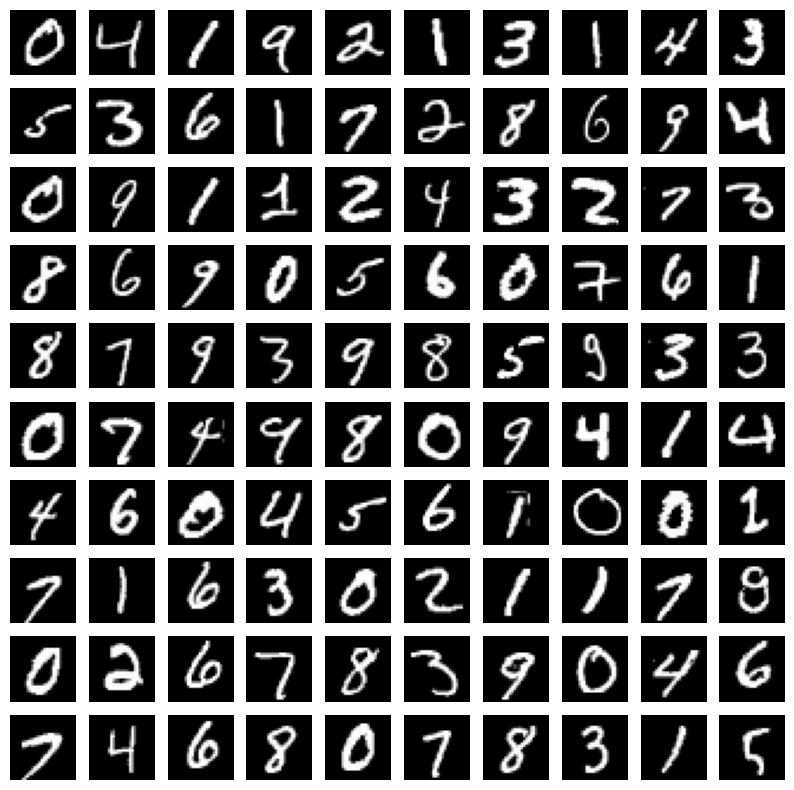

In [9]:
plt.figure(figsize=(10, 10))
for i in range(1, 101, 1):
  plt.subplot(10, 10, i)
  plt.imshow((train_dataset.data[i]), cmap='gray')
  plt.axis('off')
plt.show

In [10]:
class Teacher(nn.Module):
  def __init__(self, num_classes):
    super(Teacher, self).__init__()
    self.conv1 = nn.Conv2d(1, 256, 3, 1, 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(256, 512, 3, 1, 1)
    self.fc = nn.Linear(512 * 7 * 7, num_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    #flatten here
    x = x.view(-1, 8 * 7 * 7)
    #fc connect
    x = self.fc(x)
    return x

In [ ]:
def train_without_kd(model, optimizer, num_epochs):
  for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    #for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
     # data = data.to(device=device)
     # targets = targets.to(device=device)
     for batch_idx, (data, targets) in loop:
         data = data.to(device=device)
         targets = targets.to(device=device) #inject or ensure get the data from Cuda
         #forward
         logits = model(data)
         loss = nn.CrossEntropyLoss()(logits, targets)
         #backprop
         optimizer.zero_grad()
         loss.backward()
         #gradient descent or adam step
         optimizer.step()
         loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]") #ensure update epoc+1
         loop.set_postfix(loss=loss.item()) #should it be here?


In [ ]:
def train_with_kd(model, optimizer, num_epochs, T=1):
  for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        #forward
        logits = model(data)
        loss = 0.85*nn.CrossEntropyLoss()(logits, targets) + 0.15*(T**2)*nn.KLDivLoss(reduction="batchmean")(torch.softmax(logits/T, 1), get_probs(data, teacher))
        #Backward
        optimizer.zero_grad()
        loss.backward()
        #Gradient descent or adam step
        optimizer.step()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())##again does it needs to be here?


In [ ]:
#Get accuracy and its perforamnce (train and test)
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    #no tracking the gradient --> wrap it with torch.grad()
    with torch.no_grad():
         for x, y in loader:
             x = x.to(device=device)
             y = y.to(device=device)
             logits = model(x)
             _, predictions = logits.max(1)
             num_correct += (predictions == y).sum() #checking correctness
             num_samples += predictions.size(0) #checking num of samples
    model.train()
    return num_correct / num_samples

In [ ]:
def get_probs(batch_features, model, T=1):
    model.eval()

    with torch.no_grad():
         for x, y in loader:
             x = x.to(device=device)
             y = y.to(device=device)
             logits = model(x)
             probs = torch.softmax(logits/T, 1)
    model.train()
    return probs

In [ ]:
"# Conceptual - not runnable as is, assumes many things are predefined
# (teacher_model, student_model, dataloader, optimizer, T, alpha)

# student_model.train()
# teacher_model.eval() # If teacher is a local model

for batch in dataloader:
    inputs = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    # Assuming teacher_logits_batch contains pre-computed teacher logits for this batch
    teacher_logits_for_batch = batch['teacher_logits'].to(device)

    optimizer.zero_grad()

    # Get student predictions
    student_outputs = student_model(inputs, attention_mask=attention_mask)
    student_logits = student_outputs.logits

    # Calculate distillation loss (e.g., KL divergence)
    # Logits are typically used directly with CrossEntropyLoss if it includes softmax
    # For KLDivLoss, inputs should be log-probabilities and targets probabilities
    loss_kd = torch.nn.functional.kl_div(
        input=torch.nn.functional.log_softmax(student_logits / T, dim=-1),
        target=torch.nn.functional.softmax(teacher_logits_for_batch / T, dim=-1),
        reduction='batchmean' # or 'sum'
    ) * (T * T) # Scaling factor often used

    # If you also have a task-specific loss (e.g., from hard labels)
    # hard_labels = batch['labels'].to(device)
    # loss_task = torch.nn.functional.cross_entropy(student_logits, hard_labels)
    # total_loss = alpha * loss_kd + (1 - alpha) * loss_task
    total_loss = loss_kd # If only using distillation loss

    total_loss.backward()
    optimizer.step()

    # Log metrics, etc.

[Video to Follow](https://www.youtube.com/watch?v=9guKFI_yVNc&ab_channel=NeuralBlackMagic)